In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from time import time

import struct

In [2]:

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        with open(labels_filepath, 'rb') as file:
            magic, num_labels = struct.unpack(">II", file.read(8))
            labels = np.frombuffer(file.read(), dtype=np.uint8)

        with open(images_filepath, 'rb') as file:
            magic, num_images, rows, cols = struct.unpack(">IIII", file.read(16))
            images = np.frombuffer(file.read(), dtype=np.uint8)
            images = images.reshape(num_images, rows * cols)
            images = images / 255.0

        return images, np.eye(10)[labels]

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
from pathlib import Path

DATA_DIR = Path("./")

In [4]:
input_path = DATA_DIR / "mnist"
training_images_filepath = input_path / 'train-images-idx3-ubyte/train-images-idx3-ubyte'
training_labels_filepath = input_path / 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_filepath = input_path / 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_filepath = input_path / 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

print("Train datasize: x_train=", len(x_train), ", y_train", len(y_train))
print("Train datasize: x_train=", len(x_test), ", y_train", len(y_test))

print("x_train sample shape", x_train[0].shape)
print("y_train sample shape", y_train[0].shape)

print("x_train sample max:", np.max(x_train[0]), ", min", np.min(x_train[0]))
print("y_train sample:", y_train[0])



Train datasize: x_train= 60000 , y_train 60000
Train datasize: x_train= 10000 , y_train 10000
x_train sample shape (784,)
y_train sample shape (10,)
x_train sample max: 1.0 , min 0.0
y_train sample: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


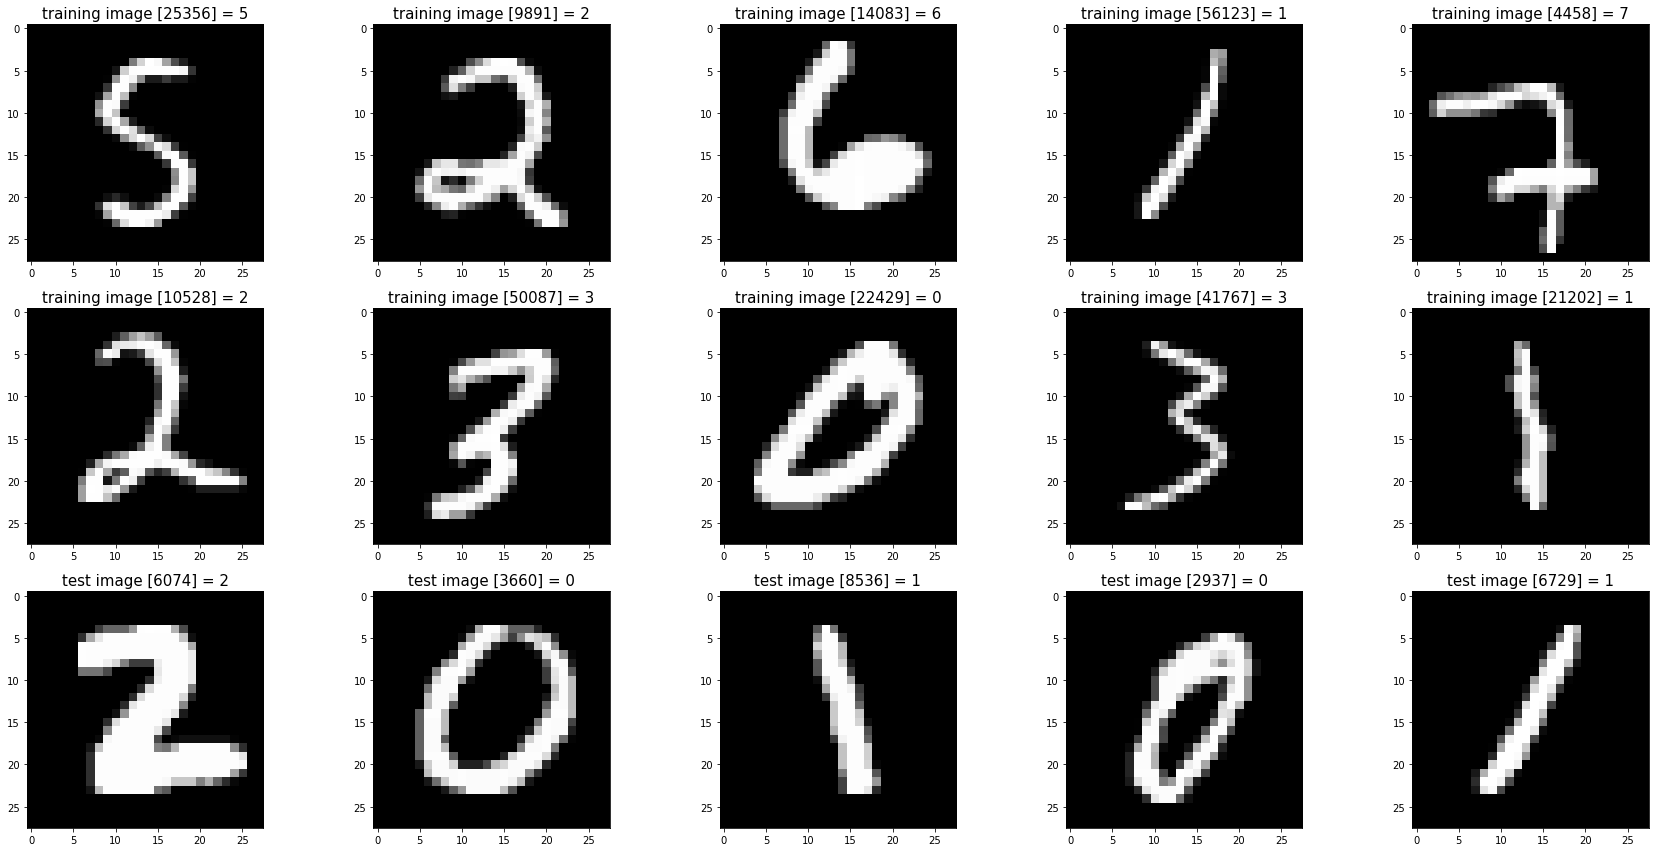

In [5]:
%matplotlib inline

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for image, title_text in zip(images, title_texts):
        plt.subplot(rows, cols, index)
        plt.imshow(image.reshape(28, 28), cmap=getattr(plt.cm, "gray", None))
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)
        index += 1

images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(np.argmax(y_train[r])))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(np.argmax(y_test[r])))

show_images(images_2_show, titles_2_show)

In [6]:
def relu(input):
    return np.maximum(0, input)

def relu_derivative(input):
    return input > 0

def softmax(input):
    exp = np.exp(input - np.max(input, axis=1, keepdims=True))
    return exp / exp.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

In [7]:
class Model:
    def __init__(
        self, 
        input_size: int, 
        output_size: int,
        hidden_layer_size: int
    ):
        self.hidden_layer_weights = np.random.random((input_size, hidden_layer_size)) * math.sqrt(2.0 / input_size)
        self.hidden_layer_bias = np.zeros((1, hidden_layer_size))
        self.output_layer_weights = np.random.random((hidden_layer_size, output_size)) * math.sqrt(2.0 / hidden_layer_size)
        self.output_layer_bias =  np.zeros((1, output_size))

    def forward_with_grad(self, input):
        self.fc1 = input.dot(self.hidden_layer_weights) + self.hidden_layer_bias
        self.relu1 = relu(self.fc1)
        self.fc2 = self.relu1.dot(self.output_layer_weights) + self.output_layer_bias
        self.softmax1 = softmax(self.fc2)
        return self.softmax1

    def forward(self, input): 
        fc1 = input.dot(self.hidden_layer_weights) + self.hidden_layer_bias
        relu1 = relu(fc1)
        fc2 = relu1.dot(self.output_layer_weights) + self.output_layer_bias
        softmax1 = softmax(fc2)
        return softmax1
    
    def backward(self, input, input_pred, gt, learning_rate=0.1):
        m = gt.shape[0]
        
        d_ce_sm = input_pred - gt
        d_fc2_w = (self.relu1.T).dot(d_ce_sm) / m
        d_fc2_bias = np.sum(d_ce_sm, axis=0, keepdims=True) / m
        d_fc2 = d_ce_sm.dot(self.output_layer_weights.T)
        d_relu = d_fc2 * relu_derivative(self.fc1)
        d_fc1_w = (input.T).dot(d_relu) / m
        d_fc1_bias = np.sum(d_relu, axis=0, keepdims=True) / m

        self.hidden_layer_weights -= learning_rate * d_fc1_w
        self.hidden_layer_bias -= learning_rate * d_fc1_bias
        self.output_layer_weights -= learning_rate * d_fc2_w
        self.output_layer_bias -= learning_rate * d_fc2_bias
        self.fc1 = None
        self.relu1 = None
        self.fc2 = None
        self.softmax1 = None
        
        return d_fc1_w, d_fc1_bias, d_fc2_w, d_fc2_bias

In [8]:
input_size = 784  # 28x28 pixels
hidden_size = 300
output_size = 10
learning_rate = 0.1
batch_size = 64
epochs = 20

model = Model(
    input_size=input_size,
    output_size=output_size,
    hidden_layer_size=hidden_size
)
for epoch in range(epochs):
    print(f"---------------- Epoch {epoch + 1} ----------------")
    permutation = np.random.permutation(x_train.shape[0])
    x_train_shuffled = x_train[permutation]
    y_train_shuffled = y_train[permutation]
    
    start_time = time()
    losses = []
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        
        output = model.forward_with_grad(x_batch)
        loss = cross_entropy_loss(output, y_batch)
        losses.append(loss)
        model.backward(x_batch, output, y_batch, learning_rate)
    
    output = model.forward(x_train)
    train_accuracy = np.mean(np.argmax(output, axis=1) == np.argmax(y_train, axis=1))
    loss_mean = np.mean(losses)
    
    end_time = time()
    print(f"Time {end_time - start_time:.2f} secodns")
    print(f"Loss mean: {loss_mean:.4f}")
    print(f"Train accurancy: {train_accuracy:.4f}")
    
    eval_output = model.forward(x_test)
    test_accuracy = np.mean(np.argmax(eval_output, axis=1) == np.argmax(y_test, axis=1))
    print(f"Test accuracy: {test_accuracy:.4f}")

---------------- Epoch 1 ----------------
Time 5.31 secodns
Loss mean: 5.9242
Train accurancy: 0.9222
Test accuracy: 0.9241
---------------- Epoch 2 ----------------
Time 4.68 secodns
Loss mean: 2.4931
Train accurancy: 0.9389
Test accuracy: 0.9363
---------------- Epoch 3 ----------------
Time 4.58 secodns
Loss mean: 1.9803
Train accurancy: 0.9549
Test accuracy: 0.9544
---------------- Epoch 4 ----------------
Time 4.40 secodns
Loss mean: 1.6515
Train accurancy: 0.9594
Test accuracy: 0.9578
---------------- Epoch 5 ----------------
Time 4.24 secodns
Loss mean: 1.4183
Train accurancy: 0.9693
Test accuracy: 0.9660
---------------- Epoch 6 ----------------
Time 4.20 secodns
Loss mean: 1.2471
Train accurancy: 0.9724
Test accuracy: 0.9666
---------------- Epoch 7 ----------------
Time 4.23 secodns
Loss mean: 1.1132
Train accurancy: 0.9734
Test accuracy: 0.9684
---------------- Epoch 8 ----------------
Time 4.18 secodns
Loss mean: 1.0143
Train accurancy: 0.9781
Test accuracy: 0.9727
--------